# Check audio and textgrid outputs

In [1]:
import sys, re
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import scipy.io.wavfile as wavfile
from parselmouth import Sound
from parselmouth.praat import call as pcall
from scipy.signal import welch
import matplotlib.pyplot as plt
from IPython.display import Audio

from audiolabel import df2tg, read_label
from phonlab.utils import dir2df, get_timestamp_now

import ceti

In [2]:
tstamp = '2023-11-29T162357'
sheet_id = '1DeQQ-ZDuCumWMz21ouxfJpeSzyRAJykX'
sheet_name = 'Sheet1'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
url = f'https://docs.google.com/spreadsheets/d/1DeQQ-ZDuCumWMz21ouxfJpeSzyRAJykX/gviz/tq?tqx=out:csv&sheet={sheet_name}'

In [3]:
# Data locations
cetidir = Path('/global/scratch/users/rsprouse/datasets/ceti')
flacdir = cetidir / 'CETIdata'
tgdir = cetidir / 'tg'
specdir = cetidir / 'spec'

# Analysis params
resample_rate = 120000
click_offset = -0.002
click_window = 0.015
click_window_str = '{}'.format(click_window).lstrip('0')
ltas_bw = 100 # Praat 'To Ltas...' bandwidth param
praat_spec_fast = False  # Praat 'To Spectrum...' fast param
dropIPI = True # If True, drop IPI# columns from google codas spreadsheet

In [4]:
# Corrections to Jocasta spreadsheet data
jocastabadcodas = [str(n) for n in range(8627, 8671)]
jocastaoffset = 0.1537  # Time to subtract from TsTo for codas in `jocastabadcodas`

## Load flac info

In [5]:
flacdf = ceti.load_flac_info(flacdir)
flacdf

,relpath,fname,barename,ext,tag,fseq,flacrate,flacdur,foffset
0,2014,sw092a001.flac,sw092a001,.flac,sw092a,1,120000,8059.957633,0.000000
1,2014,sw092a002.flac,sw092a002,.flac,sw092a,2,120000,3718.995833,8059.957633
2,2014,sw106a001.flac,sw106a001,.flac,sw106a,1,120000,8275.352133,0.000000
3,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133
4,2014,sw106a003.flac,sw106a003,.flac,sw106a,3,120000,8277.154567,16552.473500
...,...,...,...,...,...,...,...,...,...
179,2018,sw143a006.flac,sw143a006,.flac,sw143a,6,120000,6105.446233,31895.576967
180,2018,sw143a007.flac,sw143a007,.flac,sw143a,7,120000,6095.888633,38001.023200
181,2018,sw143a008.flac,sw143a008,.flac,sw143a,8,120000,4806.057675,44096.911833
182,2018,sw18136a001.flac,sw18136a001,.flac,sw18136a,1,120000,7446.831567,0.000000


In [6]:
# Merge classifiedCodas spreadsheet with available .flac files in flacdir.
# Only codas with matching .flac files are in the result.
gsheetdf = ceti.load_classified_codas(
    url,
    dropIPI=dropIPI,
    jocastacorrections={'codas':jocastabadcodas, 'offset': jocastaoffset}
)
gclicks = ceti.codadf2clickdf(gsheetdf, 'codaNUM2018', 'TsTo')
navalues = {
    k: '' for k in \
        ['codaNUM2018', 'Date', 'ELKI2name', 'IDN', 'Name', 'REC', 'Tag', 'TagOnTime', 'Unit']
}
gclicks = flacdf.merge(
    gclicks,
    how='inner',
    on='barename'
).fillna(navalues)
gclicks['extract_t1'] = gclicks['t1'] - gclicks['foffset'] + click_offset
gclicks['extract_t2'] = gclicks['extract_t1'] + click_window
# Handle this after removing rows:
gclicks.head(50)

,relpath,fname,barename,ext,tag,fseq,flacrate,flacdur,foffset,codaNUM2018,...,TagOnTime,Name,Clan,Whale,REC,CodaType,ICI,t1,extract_t1,extract_t2
0,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.038208,10000.404100,1725.049967,1725.064967
1,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.042742,10000.442308,1725.088175,1725.103175
2,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.044058,10000.485050,1725.130917,1725.145917
3,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.041092,10000.529108,1725.174975,1725.189975
4,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.048275,10000.570200,1725.216067,1725.231067
5,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.049517,10000.618475,1725.264342,1725.279342
6,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.057583,10000.667992,1725.313858,1725.328858
7,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.065133,10000.725575,1725.371442,1725.386442
8,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8169,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,9i,0.000000,10000.790708,1725.436575,1725.451575
9,2014,sw106a002.flac,sw106a002,.flac,sw106a,2,120000,8277.121367,8275.352133,8170,...,10:50:14,FRUIT,EC1,1,sw106a002_9999,8i,0.035699,10005.577700,1730.223567,1730.238567


## Load compiled textgrid

In [7]:
tgpat = re.compile(f'allclicks.(?P<tstamp>{tstamp}).(?P<nsamp>[^\.]+)samples')
tgdf = dir2df(cetidir, fnpat=tgpat, addcols=['barename', 'ext'])
assert(len(tgdf) == 1)
tgdf

,relpath,fname,barename,ext,tstamp,nsamp
0,.,allclicks.2023-11-29T162357.1800samples.TextGrid,allclicks.2023-11-29T162357.1800samples,.TextGrid,2023-11-29T162357,1800


In [8]:
[whaledf, codadf, clickdf] = read_label(
    cetidir / tgdf.iloc[0]['relpath'] / tgdf.iloc[0]['fname'],
    tiers=['whale', 'coda', 'clicknum'],
    ftype='praat'
)
# codas contain clicks
assert(codadf.t1.isin(clickdf.t1).all())
assert(codadf.t2.isin(clickdf.t2).all())

# whales contain codas
assert(whaledf.t1.isin(codadf.t1).all())
assert(whaledf.t2.isin(codadf.t2).all())

clickdf = pd.merge_asof(
    clickdf.rename({'t1': 't1_click', 't2': 't2_click'}, axis='columns'),
    codadf.drop('fname', axis='columns') \
          .rename({'t1': 't1_coda', 't2': 't2_coda'}, axis='columns'),
    left_on='t1_click',
    right_on='t1_coda'
)
clickdf = pd.merge_asof(
    clickdf.rename({'t1': 't1_click', 't2': 't2_click'}, axis='columns'),
    whaledf.drop('fname', axis='columns') \
          .rename({'t1': 't1_whale', 't2': 't2_whale'}, axis='columns'),
    left_on='t1_click',
    right_on='t1_whale'
)
clickdf = clickdf.reset_index(names='audidx')
clickdf

,audidx,t1_click,t2_click,clicknum,fname,t1_coda,t2_coda,coda,t1_whale,t2_whale,whale
0,0,0.000,0.015,1,/global/scratch/users/rsprouse/datasets/ceti/a...,0.000,0.075,4933,0.000,89.955,ATWOOD
1,1,0.015,0.030,2,/global/scratch/users/rsprouse/datasets/ceti/a...,0.000,0.075,4933,0.000,89.955,ATWOOD
2,2,0.030,0.045,3,/global/scratch/users/rsprouse/datasets/ceti/a...,0.000,0.075,4933,0.000,89.955,ATWOOD
3,3,0.045,0.060,4,/global/scratch/users/rsprouse/datasets/ceti/a...,0.000,0.075,4933,0.000,89.955,ATWOOD
4,4,0.060,0.075,5,/global/scratch/users/rsprouse/datasets/ceti/a...,0.000,0.075,4933,0.000,89.955,ATWOOD
...,...,...,...,...,...,...,...,...,...,...,...
19510,19510,292.650,292.665,4,/global/scratch/users/rsprouse/datasets/ceti/a...,292.605,292.665,8167,282.825,292.725,UNID
19511,19511,292.665,292.680,1,/global/scratch/users/rsprouse/datasets/ceti/a...,292.665,292.725,8168,282.825,292.725,UNID
19512,19512,292.680,292.695,2,/global/scratch/users/rsprouse/datasets/ceti/a...,292.665,292.725,8168,282.825,292.725,UNID
19513,19513,292.695,292.710,3,/global/scratch/users/rsprouse/datasets/ceti/a...,292.665,292.725,8168,282.825,292.725,UNID


## Find compiled .wav files

In [22]:
wavpat = re.compile(f'allclicks.(?P<chan>[^\.]+).(?P<tstamp>{tstamp}).(?P<scaling>[^\.]+).(?P<nsamp>[^\.]+)samples')
wavdf = dir2df(cetidir, fnpat=wavpat, addcols=['barename', 'ext'])
print(wavdf.iloc[0]['barename'])

allclicks.left.2023-11-29T162357.pknorm.1800samples


## Match source .flac click to compiled audio

In [77]:
compiledfname = cetidir / 'allclicks.left.2023-11-29T162357.pknorm.1800samples.wav'
compiledrate, data = wavfile.read(compiledfname, mmap=True)
compiledclicks = data.reshape([-1,1800])

In [96]:
(compiledclicks - srcclick).shape #.sum(axis=-1).min()

(19515, 1800)

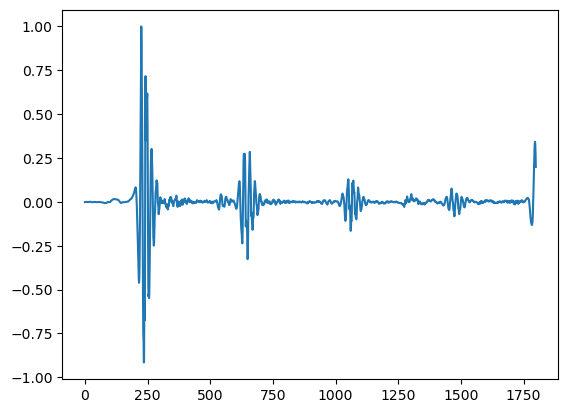

In [108]:
plt.plot(compiledclicks[10000,:]) #(compiledclicks - srcclick)[195,:]);

Read from time 14648.6290919 in /global/scratch/users/rsprouse/datasets/ceti/CETIdata/2015/sw090a.flac
       audidx  t1_click  t2_click clicknum  \
10130   10130    151.95   151.965        2   

                                                   fname  t1_coda  t2_coda  \
10130  /global/scratch/users/rsprouse/datasets/ceti/a...  151.935   152.01   

       coda  t1_whale  t2_whale whale  
10130  7434    89.955   158.925  FORK  


(Pandas(Index=12482, relpath='2015', fname='sw090a002.flac', barename='sw090a002', ext='.flac', tag='sw090a', fseq=2, flacrate=120000, flacdur=8219.1675, foffset=8261.557633333334, codaNUM2018='7086', clicknum=2, IDN='0', seg='14644', Tag='sw090a', Date='2015-03-31 00:00:00', UnitNum=3, TsTo=14648.3078, SampleRate=120000, ELKI2=nan, Focal=0.0, fileseq='002', Duration=1.005983, nClicks=5, Bout=14, ELKI2name='', Coda=1, Unit='F', TagOnTime='08:56:49', Name='PINCHY', Clan='EC1', Whale=2, REC='sw090a002_14644', CodaType='1+1+3', ICI=0.3237863, t1=14648.6310919, extract_t1=6387.0714585666665, extract_t2=6387.086458566667),
 (1800,),
 (19515, 1800),
 10130)

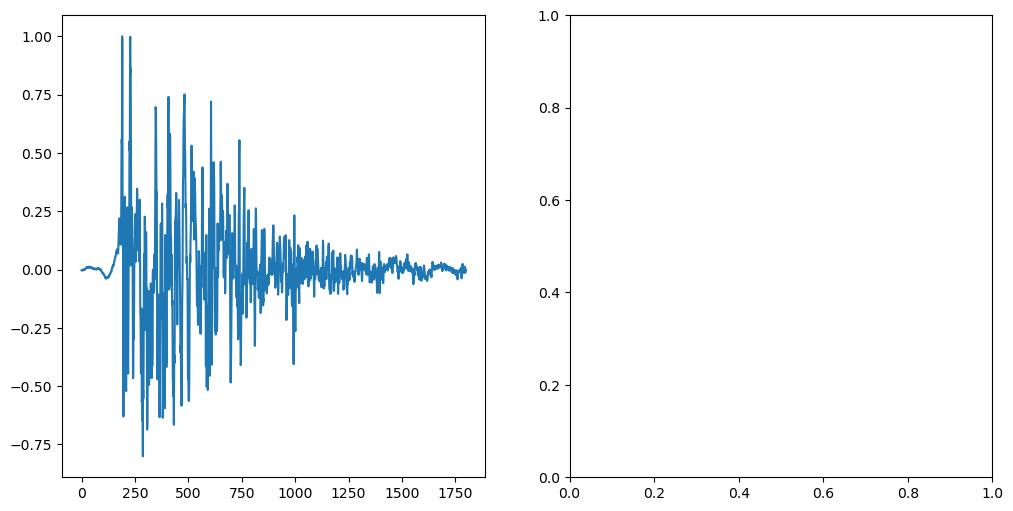

In [95]:
ntest = 1
for row in gclicks.sample(ntest).itertuples():
    aufile = flacdir / row.relpath / f'{row.Tag}.flac'
    srcclick = ceti.get_single_click_audio(
        aufile, row.t1, click_offset, click_window, resample_rate, verbose=True
    )[0,:]
    srcclick = ceti.normalize_audio(srcclick, remdc=True, peak_scale=1.0)
fig, axs = plt.subplots(1, 2, figsize=[12,6])
axs[0].plot(srcclick);
#axs[1].plot(srcclick);
print(clickdf[clickdf['audidx'] == (compiledclicks - srcclick).sum(axis=-1).argmin()])
row, srcclick.shape, compiledclicks.shape, (compiledclicks - srcclick).sum(axis=-1).argmin()

## Match compiled audio row to original source .flac file

('FORK',
 '6528:5',
 PosixPath('/global/scratch/users/rsprouse/datasets/ceti/CETIdata/2015/sw085a.flac'),
 'right',
 7304,
 'pknorm',
 1.0,
 False,
 0,
 10)

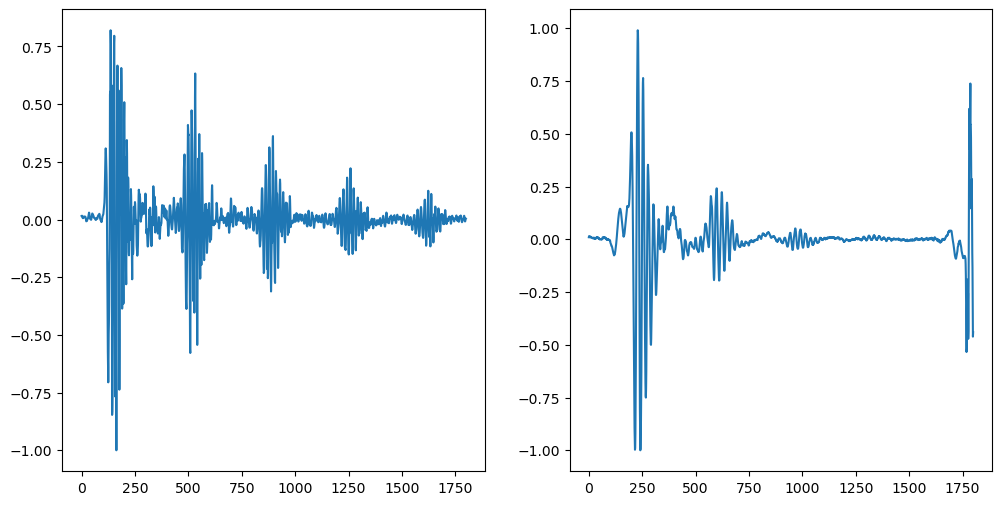

In [41]:
# Randomly test a number of audio clicks to make sure they appear in the proper order
# in `clickaudio`.
ntest = 10
errors = []
good = []
margin = 10e-7
for row in clickdf[clickdf['coda'].isin(gclicks[gclicks['Tag'] == 'sw085a']['codaNUM2018'].unique())].sample(ntest).itertuples():
#for row in clickdf.sample(ntest).itertuples():
    # Randomly pick a left|right, unscaled|pknorm compiled output file to compare with source audio.
    randwav = wavdf.sample(1)
    nsamp = int(randwav.iloc[0]['nsamp'])
    chan = 0 if randwav.iloc[0]['chan'] == 'left' else 1
    peak_scale = None if randwav.iloc[0]['scaling'] == 'unscaled' else 1.0
    compiledfname = cetidir / randwav.iloc[0]['relpath'] / randwav.iloc[0]['fname']
    compiledrate, data = wavfile.read(compiledfname, mmap=True)
    compiledclick = data.reshape([-1,nsamp])[row.audidx,:]

    # Load corresponding source audio.
    gcoda = gclicks[(gclicks['codaNUM2018'] == row.coda)].sort_values('t1')
    srcclick = gcoda.iloc[int(row.clicknum) - 1]
    assert(row.whale == srcclick['Name'])
    srcfile = flacdir / srcclick.relpath / f'{srcclick.Tag}.flac'
    with sf.SoundFile(srcfile, 'r') as fh:
        sr_native = fh.samplerate
        try:
            fh.seek(int((srcclick.t1 + click_offset) * sr_native))
        except Exception as e:
            errors.append({'reason': str(e), 'row': row, 'randwav': randwav, 'srcclick': srcclick, 'srcaud': srcaud, 'compiledclick': compiledclick})
        # Load the target number of frames, and transpose to match librosa form
        srcaud = fh.read(frames=int(click_window * sr_native), dtype=np.float32, always_2d=False).T
        if sr_native != compiledrate:
            srcaud = librosa.resample(srcaud, orig_sr=sr_native, target_sr=compiledrate)
    srcaud = ceti.normalize_audio(srcaud[chan], remdc=True, peak_scale=peak_scale)
    try:
        assert(((compiledclick - srcaud) < margin).all())
        good.append({'reason': None, 'row': row, 'randwav': randwav, 'srcclick': srcclick, 'srcaud': srcaud, 'compiledclick': compiledclick})
    except AssertionError:
        errors.append({'reason': 'margin', 'row': row, 'randwav': randwav, 'srcclick': srcclick, 'srcaud': srcaud, 'compiledclick': compiledclick})
#        sys.stderr.write(f'Click data not within margin of error for row {row},\nrandwav {randwav},\nsrcclick {srcclick}.\n\n\n')
fig, axs = plt.subplots(1, 2, figsize=[12,6])
axs[0].plot(compiledclick);
axs[1].plot(srcaud);
row.whale, f'{row.coda}:{row.clicknum}', srcfile, randwav.iloc[0]['chan'], row.audidx, randwav.iloc[0]['scaling'], peak_scale, ((compiledclick - srcaud) < margin).all(), len(good), len(errors)

In [171]:
(srcclick.t1 + click_offset)

1963.1394167

In [169]:
errors[0]['srcclick'] #.iloc[:, ['foffset', 't1', 'extract_t1']]

relpath                       2015
fname               sw085a001.flac
barename                 sw085a001
ext                          .flac
tag                         sw085a
fseq                             1
flacrate                    120000
flacdur                  8261.5418
foffset                        0.0
codaNUM2018                   6643
clicknum                         3
REC                 sw085a001_2121
ELKI2name                         
ELKI2                          NaN
Whale                            1
TsTo                     2239.1971
TagOnTime                 08:53:04
Focal                          1.0
Name                          FORK
Duration                  1.293133
Bout                            13
Clan                           EC1
IDN                           5151
SampleRate                  120000
UnitNum                         11
Tag                         sw085a
Unit                             U
nClicks                          5
Coda                

In [162]:
[errors[i]['srcclick']['foffset'] for i in range(len(errors))]

[0.0]

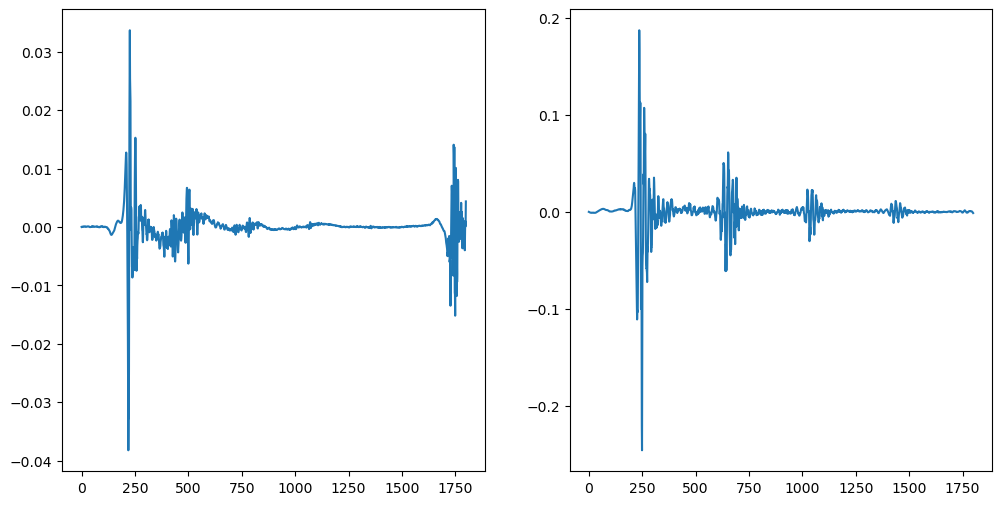

In [164]:
idx = 0
plotlist = errors
#plt.plot(plotlist[idx]['compiledclick'] - plotlist[idx]['srcaud']);
fig, axs = plt.subplots(1, 2, figsize=[12,6])
axs[0].plot(plotlist[idx]['compiledclick']);
axs[1].plot(plotlist[idx]['srcaud']);


In [60]:
(compiledclick == srcaud).all()

True

In [20]:
gclicks[gclicks['Tag'] == 'sw133a']['codaNUM2018'].unique()

array(['8627', '8628', '8629', '8630', '8631', '8632', '8633', '8634',
       '8635', '8636', '8637', '8638', '8639', '8640', '8641', '8642',
       '8643', '8644', '8645', '8646', '8647', '8648', '8649', '8650',
       '8651', '8652', '8653', '8654', '8655', '8656', '8657', '8658',
       '8659', '8660', '8661', '8662', '8663', '8664', '8665', '8666',
       '8667', '8668', '8669', '8670', '8671', '8672', '8673', '8674',
       '8675', '8676', '8677', '8678'], dtype=object)

In [73]:
len(errors)

3

In [159]:
randwav.iloc[0]['scaling'] == 'unscaled'

True

In [150]:
srcclick = gclicks[(gclicks['codaNUM2018'] == row.coda)].iloc[int(row.clicknum) - 1]
srcclick.relpath

'2015'